In [ ]:
import os

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Multiply, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

from tensorflow.keras.initializers import GlorotUniform, HeNormal, HeUniform, GlorotNormal

import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [ ]:
ratings = pd.read_csv('./drive/MyDrive/imdb-rating/ml_detail.csv', sep=',', encoding='latin-1')

In [ ]:
ratings.head()

,movie id,user id,rating,content,date,movie index,user index
0,tt0102813,ur0391152,2,I've always had kind of a perverse curiosity a...,22 August 2010,6914,81
1,tt0387808,ur0391152,5,20th Century Fox was moronic not to release th...,6 November 2006,3393,81
2,tt0845046,ur0391152,5,It's the kind of movie that reminds me that th...,28 September 2008,3507,81
3,tt0113824,ur0391152,5,"A very moving animÃ© film from Studio Ghibli, ...",29 September 2003,3181,81
4,tt0455538,ur0391152,2,Based on the autobiographical tale of writer T...,6 October 2008,4699,81


In [ ]:
ratings = ratings[['user index', 'movie index', 'rating']]

In [ ]:
ratings = ratings.drop_duplicates(subset=['user index', 'movie index'], keep='first')

In [ ]:
movie_list = pd.read_csv('./drive/MyDrive/imdb-movie/ml_detail.csv', encoding='latin-1', sep=',')

In [ ]:
movie_list.head()

,movie id,title,series,release year,certification,duration,average rating,rating total,genre list,content,countries of origin,official sites,languages,production companies,budget,movie index,Musical,Drama,News,Film-Noir,Talk-Show,Fantasy,Family,Action,Adventure,War,Thriller,Animation,Documentary,Comedy,Reality-TV,Western,Romance,Horror,Biography,Game-Show,Mystery,History,Music,Short,Sport,Sci-Fi,Crime,image_url
0,tt0102813,Rover Dangerfield,NaN,1991,G,1h 14m,6.0,3K,Animation|Comedy|Family,A Vegas show dog gets ditched in the sticks an...,United States,NaN,English,NaN,NaN,6914,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,https://m.media-amazon.com/images/M/MV5BYmUyNW...
1,tt1086761,Keeping Up with the Kardashians,TV Series,2006â2021,TV-14,44m,2.8,29K,Drama|Family|Reality-TV,A peek inside the exploits and privileged priv...,United States,Official sites|Official Facebook|Official Inst...,English|Spanish,NaN,NaN,3783,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,https://m.media-amazon.com/images/M/MV5BMjJhMz...
2,tt0075686,Annie Hall,NaN,1977,PG,1h 33m,8.0,259K,Comedy|Romance,"Alvy Singer, a divorced Jewish comedian, refle...",United States,NaN,English|German,NaN,"$38,287,178",4554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,https://m.media-amazon.com/images/M/MV5BZDg1OG...
3,tt1402488,Happy Feet Two,NaN,2011,PG,1h 40m,5.9,44K,Animation|Adventure|Comedy,"Mumble's son, Erik, is struggling to realize h...",Australia|United States|Antarctica|New Zealand,Official site,English,NaN,"$159,197,038",3340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,https://m.media-amazon.com/images/M/MV5BMTg1Mz...
4,tt1087461,Megan Is Missing,NaN,2011,Not Rated,1h 25m,4.5,12K,Drama|Horror|Thriller,Two teenage girls encounter an Internet child ...,United States,MySpace|Official site,English,NaN,NaN,6742,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,https://m.media-amazon.com/images/M/MV5BMTU0Nz...


In [ ]:
num_users  = len(ratings['user index'].value_counts())
num_items  = len(ratings['movie index'].value_counts())
print(num_users, num_items)
sparsity = round(1.0 - len(ratings)/(1.0*(num_users*num_items)),3)
print(sparsity)

1390 8352
0.992


In [ ]:
user_maxId = num_users - 1
item_maxId = num_items - 1

In [ ]:
ratings

,user index,movie index,rating
0,81,6914,2
1,81,3393,5
2,81,3507,5
3,81,3181,5
4,81,4699,2
...,...,...,...
93241,1326,6147,5
93242,1326,6277,1
93243,1326,6876,1
93244,1326,7319,4


In [ ]:
df_user_item = ratings.pivot(index='user index', columns='movie index', values='rating')
    # reset movieId
df_user_item = df_user_item.T.reset_index(drop=True).T
ratings.pivot(index='user index', columns='movie index', values='rating').T.reset_index(drop=True).T.reset_index('user index').melt(
            id_vars='user index',
            value_vars=df_user_item.columns,
            var_name='movie index',
            value_name='rating')

,user index,movie index,rating
0,0,0,NaN
1,1,0,NaN
2,2,0,4.0
3,3,0,NaN
4,4,0,NaN
...,...,...,...
11609275,1385,8351,NaN
11609276,1386,8351,NaN
11609277,1387,8351,NaN
11609278,1388,8351,NaN


In [ ]:
def reduce_item_dim(df_ratings):
    # pivot
    df_user_item = df_ratings.pivot(index='user index', columns='movie index', values='rating')
    # reset movieId
    df_user_item = df_user_item.T.reset_index(drop=True).T
    # undo pivot/melt - compress data frame
    df_ratings_new = df_user_item \
        .reset_index('user index') \
        .melt(
            id_vars='user index', 
            value_vars=df_user_item.columns,
            var_name='movie index',
            value_name='rating')
    # drop nan and final clean up
    return df_ratings_new.dropna().sort_values(['user index', 'movie index']).reset_index(drop=True)

In [ ]:
print('reduce item dimension before:')
ratings.head()

reduce item dimension before:


,user index,movie index,rating
0,81,6914,2
1,81,3393,5
2,81,3507,5
3,81,3181,5
4,81,4699,2


In [ ]:
ratings.shape

(92544, 3)

In [ ]:
ratings = reduce_item_dim(ratings)
print('reduce item dimension after:')
ratings.head()

reduce item dimension after:


,user index,movie index,rating
0,0,2,4.0
1,0,6,3.0
2,0,21,4.0
3,0,50,5.0
4,0,90,4.0


In [ ]:
ratings.shape

(92544, 3)

In [ ]:
df_ratings = ratings

In [ ]:
df_train, df_test = train_test_split(df_ratings, test_size=0.2, shuffle=True, random_state=99)
print('shape of training data set:')
print(df_train.shape)
print('shape of test data set:')
print(df_test.shape)

shape of training data set:
(74035, 3)
shape of test data set:
(18509, 3)


In [ ]:
def get_GMF_model(num_users, num_items, latent_dim, vu_reg, vi_reg, kernel):
    """
    Build Generalized Matrix Factorization Model Topology
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    latent_dim: int, embedded dimension for user vector and item vector
    vu_reg: float, L2 regularization of user embedded layer
    vi_reg: float, L2 regularization of item embedded layer

    Return
    ------
    A Keras Model with GMF model architeture
    """
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    MF_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=latent_dim,
        embeddings_initializer='uniform',
        name='user_embedding',
        embeddings_regularizer=l2(vu_reg),
        input_length=1)
    MF_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=latent_dim,
        embeddings_initializer='uniform',
        name='item_embedding',
        embeddings_regularizer=l2(vi_reg),
        input_length=1) 
    
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))

    predict_vector = Multiply()([user_latent, item_latent])
    
    prediction = Dense(1, kernel_initializer=kernel, name='prediction')(predict_vector)
    
    model = Model([user_input, item_input], prediction)
    
    return model


def train_model(model, learner, batch_size, epochs, val_split, inputs, outputs, filename):
    """
    define training routine, train models and save best model
    
    Parameters
    ----------
    model: a Keras model
    learner: str, one of ['sgd', 'adam', 'rmsprop', 'adagrad']
    batch_size: num samples per update
    epochs: num iterations
    val_split: split ratio for validation data
    inputs: inputs data
    outputs: outputs data
    """
    # add customized metric
    def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_true - y_pred)))
    
    # compile model
    model.compile(optimizer=learner.lower(), loss='mean_squared_error', metrics=['mean_squared_error', rmse])
    
    # add call backs
    early_stopper = EarlyStopping(monitor='val_rmse', patience=10, verbose=1)
    model_saver = ModelCheckpoint(filepath=filename,
                                  monitor='val_rmse',
                                  save_best_only=True,
                                  save_weights_only=True)
    # train model
    history = model.fit(inputs, outputs,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=val_split,
                        callbacks=[early_stopper, model_saver])
    return history


def load_trained_model(model, weights_path):
    model.load_weights(weights_path)
    return model

In [ ]:
import numpy as np
x = np.zeros((1,))
x

array([0.])

In [ ]:
class Metrics():
    def computeMSE(y_true, y_pred):
        error = 0
        for i in range(len(y_true)):
          error += (y_true[i] - y_pred[i]) ** 2
        return error / len(y_true)

    def computeMAE(y_true, y_pred):
        error = 0
        for i in range(len(y_true)):
          error += abs(y_true[i] - y_pred[i])
        return error / len(y_true)

    def computeSIA(y_true, y_pred, eps=1): 
        error = []
        for i in range(len(y_true)):
          error.append(abs(y_true[i] - y_pred[i]))
        bina = 0
        for err in error:
            if (err <= eps):
                bina += 1
        return bina/len(y_true)

In [ ]:
def plot_learning_curve(history, metric):
    """
    Plot learning curve to compare training error vs. validation error
    """
    # get training error
    errors = history.history[metric]
    # get validation error
    val_errors = history.history['val_{}'.format(metric)]
    # get epochs
    epochs = range(1, len(errors) + 1)

    # plot
    plt.figure(figsize=(12, 7))
    plt.plot(epochs, errors, 'bo', label='training {}'.format(metric))
    plt.plot(epochs, val_errors, 'b', label='validation {}'.format(metric))
    plt.xlabel('number of epochs')
    plt.ylabel(metric)
    plt.title('Model Learning Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
BATCH_SIZE = 64
EPOCHS = 30
VAL_SPLIT = 0.25

  0%|          | 0/4 [00:00<?, ?it/s]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 10)        13910       ['user_input[0][0]']             
                                                                                                  
 item_embedding (Embedding)     (None, 1, 10)        83530       ['item_input[0][0]']             
                                                                                              

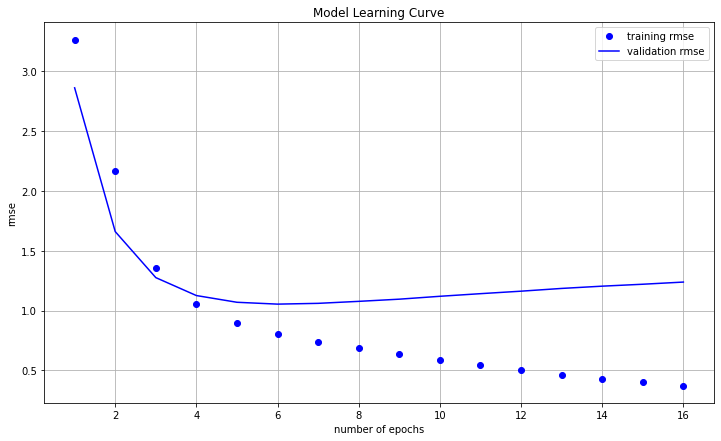

 25%|██▌       | 1/4 [01:12<03:38, 72.77s/it]

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 10)        13910       ['user_input[0][0]']             
                                                                                                  
 item_embedding (Embedding)     (None, 1, 10)        83530       ['item_input[0][0]']             
                                                                                            

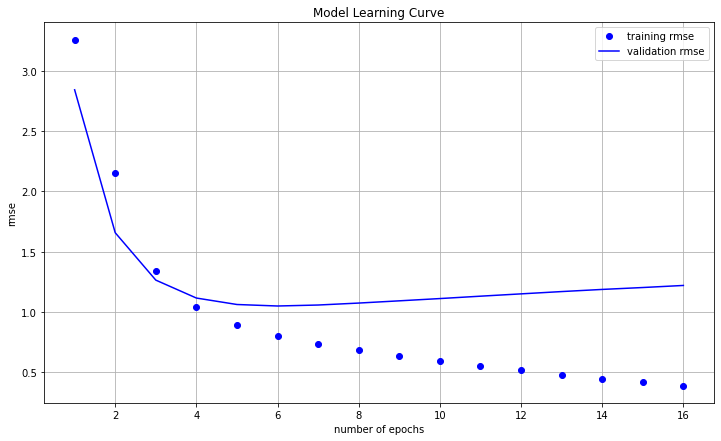

 50%|█████     | 2/4 [02:35<02:37, 78.72s/it]

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 10)        13910       ['user_input[0][0]']             
                                                                                                  
 item_embedding (Embedding)     (None, 1, 10)        83530       ['item_input[0][0]']             
                                                                                            

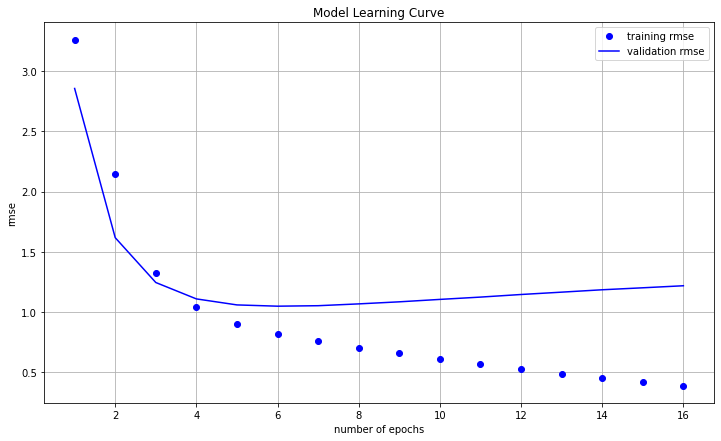

 75%|███████▌  | 3/4 [03:58<01:20, 80.71s/it]

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 10)        13910       ['user_input[0][0]']             
                                                                                                  
 item_embedding (Embedding)     (None, 1, 10)        83530       ['item_input[0][0]']             
                                                                                            

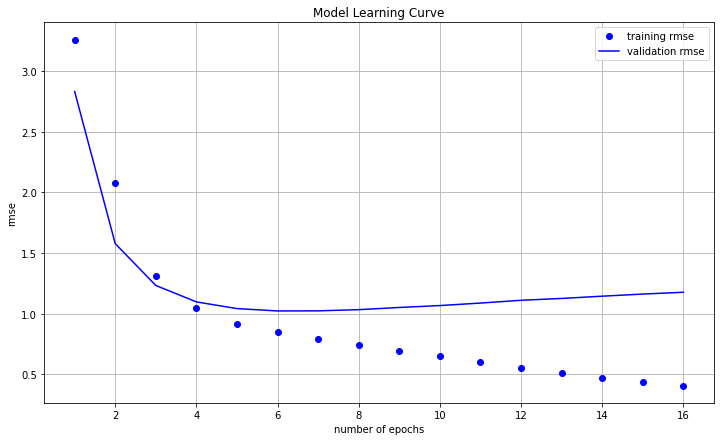

100%|██████████| 4/4 [05:21<00:00, 80.40s/it]


In [ ]:
filenames = ["./drive/MyDrive/gmf_model_glorot_normal.hdf5", "./drive/MyDrive/gmf_model_glorot_uniform.hdf5", "./drive/MyDrive/gmf_model_he_normal.hdf5", "./drive/MyDrive/gmf_model_he_uniform.hdf5"]
i = 0

for kernel in tqdm([GlorotNormal(), GlorotUniform(), HeNormal(), HeUniform()]):
  GMF_model = get_GMF_model(num_users, num_items, 10, 0, 0, kernel)
  GMF_model.summary()
  history = train_model(GMF_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT, 
                      [df_train["user index"].values.astype(np.int), df_train["movie index"].values.astype(np.int)],
                    df_train["rating"].values.astype(np.int), filenames[i])
  i = i + 1
  plot_learning_curve(history, 'rmse')



In [ ]:
y_mae_trains = []
y_mse_trains = []
y_sia_1_trains = []
y_sia_0_5_trains = []
y_sia_0_25_trains = []

y_mae_tests = []
y_mse_tests = []
y_sia_1_tests = []
y_sia_0_5_tests = []
y_sia_0_25_tests = []

In [ ]:
# load best model
filenames = ["./drive/MyDrive/gmf_model_glorot_normal.hdf5", "./drive/MyDrive/gmf_model_glorot_uniform.hdf5", "./drive/MyDrive/gmf_model_he_normal.hdf5", "./drive/MyDrive/gmf_model_he_uniform.hdf5"]
i = 0

for kernel in tqdm([GlorotNormal(), GlorotUniform(), HeNormal(), HeUniform()]):
  GMF_model = get_GMF_model(num_users, num_items, 10, 0, 0, kernel)
  GMF_model = load_trained_model(GMF_model, filenames[i])

  predictions_train = GMF_model.predict([df_train["user index"].values.astype(np.int), df_train["movie index"].values.astype(np.int)])

  y_mae_trains.append(Metrics.computeMAE(df_train.rating.values, predictions_train))
  y_mse_trains.append(Metrics.computeMSE(df_train.rating.values, predictions_train))
  y_sia_1_trains.append(Metrics.computeSIA(df_train.rating.values, predictions_train, 1))
  y_sia_0_5_trains.append(Metrics.computeSIA(df_train.rating.values, predictions_train, 0.5))
  y_sia_0_25_trains.append(Metrics.computeSIA(df_train.rating.values, predictions_train, 0.25))

  # make prediction using test data
  predictions_test = GMF_model.predict([df_test["user index"].values.astype(np.int), df_test["movie index"].values.astype(np.int)])
  
  y_mae_tests.append(Metrics.computeMAE(df_test.rating.values, predictions_test))
  y_mse_tests.append(Metrics.computeMSE(df_test.rating.values, predictions_test))
  y_sia_1_tests.append(Metrics.computeSIA(df_test.rating.values, predictions_test, 1))
  y_sia_0_5_tests.append(Metrics.computeSIA(df_test.rating.values, predictions_test, 0.5))
  y_sia_0_25_tests.append(Metrics.computeSIA(df_test.rating.values, predictions_test, 0.25))

  i = i + 1





100%|██████████| 4/4 [00:33<00:00,  8.35s/it]


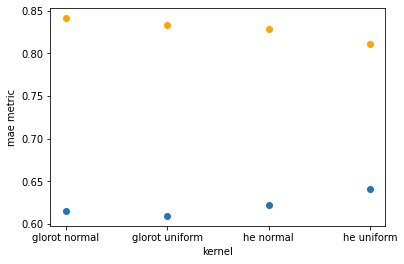

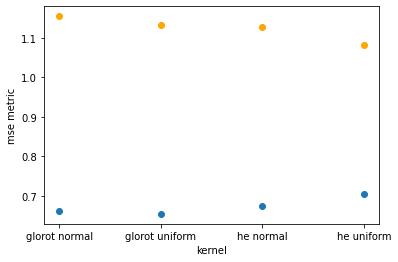

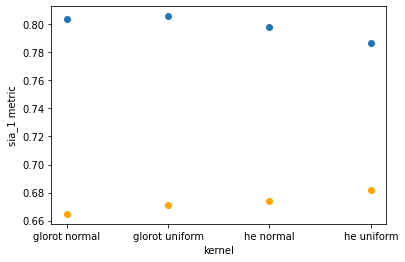

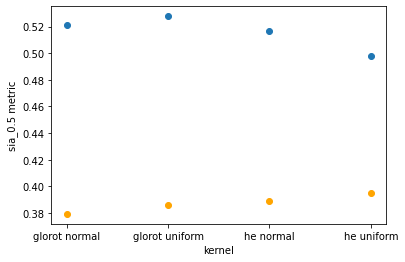

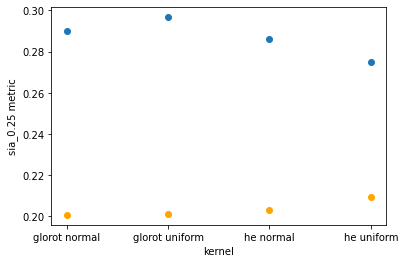

In [ ]:
X_label = ["glorot normal", "glorot uniform", "he normal", "he uniform"]

plt.scatter(X_label, y_mae_trains)
plt.scatter(X_label, y_mae_tests, color="orange")
plt.xlabel("kernel")
plt.ylabel("mae metric")
plt.show()

plt.scatter(X_label, y_mse_trains)
plt.scatter(X_label, y_mse_tests, color="orange")
plt.xlabel("kernel")
plt.ylabel("mse metric")
plt.show()

plt.scatter(X_label, y_sia_1_trains)
plt.scatter(X_label, y_sia_1_tests, color="orange")
plt.xlabel("kernel")
plt.ylabel("sia_1 metric")
plt.show()

plt.scatter(X_label, y_sia_0_5_trains)
plt.scatter(X_label, y_sia_0_5_tests, color="orange")
plt.xlabel("kernel")
plt.ylabel("sia_0.5 metric")
plt.show()

plt.scatter(X_label, y_sia_0_25_trains)
plt.scatter(X_label, y_sia_0_25_tests, color="orange")
plt.xlabel("kernel")
plt.ylabel("sia_0.25 metric")
plt.show()



In [ ]:
print(y_mae_trains)
print(y_mse_trains)
print(y_sia_1_trains)
print(y_sia_0_5_trains)
print(y_sia_0_25_trains)

print(y_mae_tests)
print(y_mse_tests)
print(y_sia_1_tests)
print(y_sia_0_5_tests)
print(y_sia_0_25_tests)

[array([0.61549167]), array([0.60920394]), array([0.62200084]), array([0.6412801])]
[array([0.66225423]), array([0.65371372]), array([0.67392402]), array([0.70381075])]
[0.8036874451273046, 0.8057810495036132, 0.7980819882488013, 0.7869521172418451]
[0.5211724184507328, 0.5277774025798608, 0.5164044033227527, 0.498196798811373]
[0.2900790166812994, 0.29662997231039373, 0.28591882217869924, 0.27509961504693725]
[array([0.84111637], dtype=float32), array([0.83295715], dtype=float32), array([0.8286759], dtype=float32), array([0.8108205], dtype=float32)]
[array([1.1551228], dtype=float32), array([1.1331006], dtype=float32), array([1.1284055], dtype=float32), array([1.0812852], dtype=float32)]
[0.6647576854503214, 0.6708087957210006, 0.6742125452482576, 0.6820465719379761]
[0.3793289750931979, 0.3860284186071641, 0.3889459182019558, 0.3953752228645524]
[0.20071316656761576, 0.20125344427035496, 0.2031984440002161, 0.209411637581717]


In [ ]:
def get_MLP_model(num_users, num_items, layers, reg_layers, kernel):
    """
    Build Multi-Layer Perceptron Model Topology
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    layers: list of int, each element is the number of hidden units for each layer,
        with the exception of first element. First element is the sum of dims of
        user latent vector and item latent vector
    reg_layers: list of int, each element is the L2 regularization parameter for
        each layer in MLP

    Return
    ------
    A Keras Model with MLP model architeture
    """
    assert len(layers) == len(reg_layers)
    num_layer = len(layers) # Number of layers in the MLP
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    MLP_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=layers[0] // 2,
        embeddings_initializer='uniform',
        name='user_embedding',
        embeddings_regularizer=l2(reg_layers[0]),
        input_length=1)
    MLP_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=layers[0] // 2,
        embeddings_initializer='uniform',
        name='item_embedding',
        embeddings_regularizer=l2(reg_layers[0]),
        input_length=1) 
    
    user_latent = Flatten()(MLP_Embedding_User(user_input))
    item_latent = Flatten()(MLP_Embedding_Item(item_input))

    vector = Concatenate(axis=-1)([user_latent, item_latent])

    for idx in range(1, num_layer):
        layer = Dense(
            units=layers[idx],
            activation='relu',
            kernel_initializer=kernel,
            kernel_regularizer=l2(reg_layers[idx]),
            name = 'layer%d' %idx)
        vector = layer(vector)
    
    prediction = Dense(1, kernel_initializer=kernel, name='prediction')(vector)
    
    model = Model([user_input, item_input], prediction)
    return model
    

In [ ]:
# model config
BATCH_SIZE = 64
EPOCHS = 30
VAL_SPLIT = 0.25

  0%|          | 0/4 [00:00<?, ?it/s]

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 32)        44512       ['user_input[0][0]']             
                                                                                                  
 item_embedding (Embedding)     (None, 1, 32)        267296      ['item_input[0][0]']             
                                                                                            

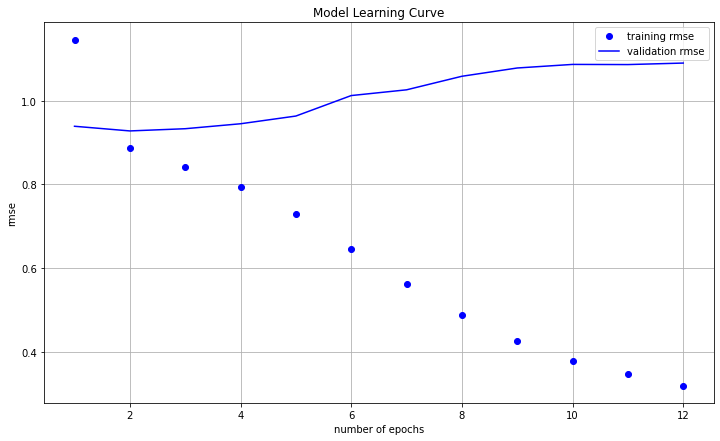

 25%|██▌       | 1/4 [00:58<02:56, 58.91s/it]

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 32)        44512       ['user_input[0][0]']             
                                                                                                  
 item_embedding (Embedding)     (None, 1, 32)        267296      ['item_input[0][0]']             
                                                                                            

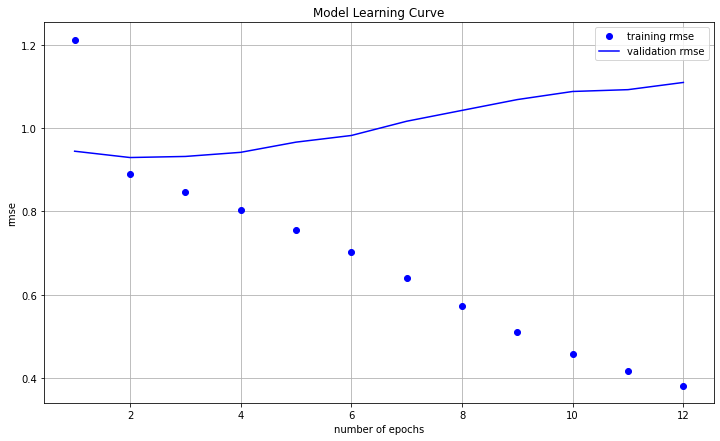

 50%|█████     | 2/4 [02:22<02:26, 73.17s/it]

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 32)        44512       ['user_input[0][0]']             
                                                                                                  
 item_embedding (Embedding)     (None, 1, 32)        267296      ['item_input[0][0]']             
                                                                                           

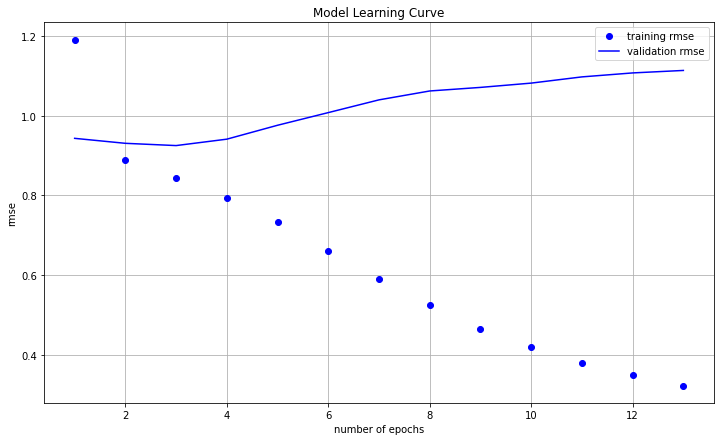

 75%|███████▌  | 3/4 [03:28<01:10, 70.02s/it]

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 32)        44512       ['user_input[0][0]']             
                                                                                                  
 item_embedding (Embedding)     (None, 1, 32)        267296      ['item_input[0][0]']             
                                                                                           

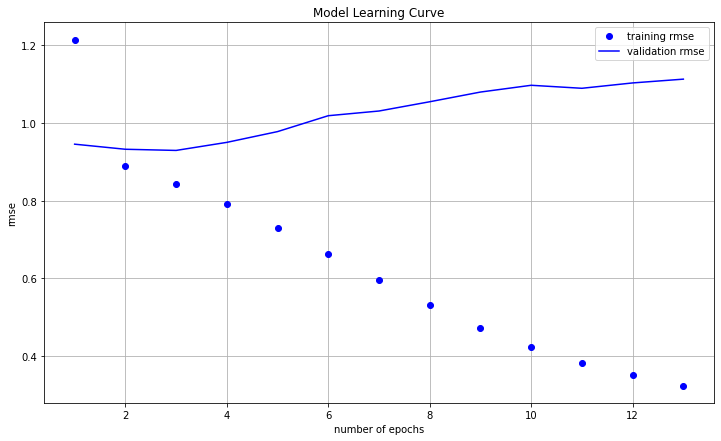

100%|██████████| 4/4 [04:33<00:00, 68.44s/it]


In [ ]:
filenames = ["./drive/MyDrive/mlp_model_glorot_normal.hdf5", "./drive/MyDrive/mlp_model_glorot_uniform.hdf5", "./drive/MyDrive/mlp_model_he_normal.hdf5", "./drive/MyDrive/mlp_model_he_uniform.hdf5"]
i = 0

for kernel in tqdm([GlorotNormal(), GlorotUniform(), HeNormal(), HeUniform()]):
  MLP_model = get_MLP_model(num_users, num_items, [64, 32, 16, 8], [0, 0, 0, 0], kernel)
  MLP_model.summary()
  
  history = train_model(MLP_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT, 
                      [df_train["user index"].values.astype(np.int), df_train["movie index"].values.astype(np.int)],
                      df_train.rating.values, filenames[i])
  i = i + 1
  plot_learning_curve(history, 'rmse')


In [ ]:
y_mae_trains = []
y_mse_trains = []
y_sia_1_trains = []
y_sia_0_5_trains = []
y_sia_0_25_trains = []

y_mae_tests = []
y_mse_tests = []
y_sia_1_tests = []
y_sia_0_5_tests = []
y_sia_0_25_tests = []

In [ ]:
# load best model
filenames = ["./drive/MyDrive/mlp_model_glorot_normal.hdf5", "./drive/MyDrive/mlp_model_glorot_uniform.hdf5", "./drive/MyDrive/mlp_model_he_normal.hdf5", "./drive/MyDrive/mlp_model_he_uniform.hdf5"]
i = 0

for kernel in tqdm([GlorotNormal(), GlorotUniform(), HeNormal(), HeUniform()]):
  MLP_model = get_MLP_model(num_users, num_items, [64, 32, 16, 8], [0, 0, 0, 0], kernel)
  MLP_model = load_trained_model(MLP_model, filenames[i])

  # make prediction using train data
  predictions_train = MLP_model.predict([df_train["user index"].values.astype(np.int), df_train["movie index"].values.astype(np.int)])

  y_mae_trains.append(Metrics.computeMAE(df_train.rating.values, predictions_train))
  y_mse_trains.append(Metrics.computeMSE(df_train.rating.values, predictions_train))
  y_sia_1_trains.append(Metrics.computeSIA(df_train.rating.values, predictions_train, 1))
  y_sia_0_5_trains.append(Metrics.computeSIA(df_train.rating.values, predictions_train, 0.5))
  y_sia_0_25_trains.append(Metrics.computeSIA(df_train.rating.values, predictions_train, 0.25))

  # make prediction using test data
  predictions_test = MLP_model.predict([df_test["user index"].values.astype(np.int), df_test["movie index"].values.astype(np.int)])

  y_mae_tests.append(Metrics.computeMAE(df_test.rating.values, predictions_test))
  y_mse_tests.append(Metrics.computeMSE(df_test.rating.values, predictions_test))
  y_sia_1_tests.append(Metrics.computeSIA(df_test.rating.values, predictions_test, 1))
  y_sia_0_5_tests.append(Metrics.computeSIA(df_test.rating.values, predictions_test, 0.5))
  y_sia_0_25_tests.append(Metrics.computeSIA(df_test.rating.values, predictions_test, 0.25))

  i = i + 1





100%|██████████| 4/4 [00:35<00:00,  8.90s/it]


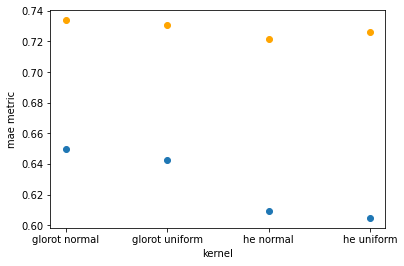

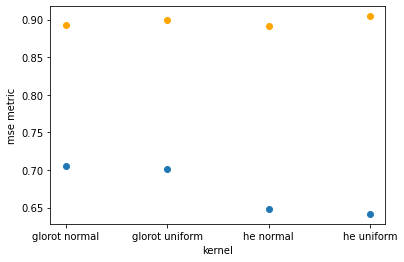

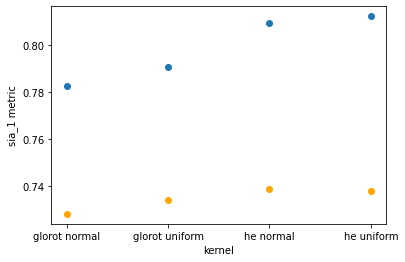

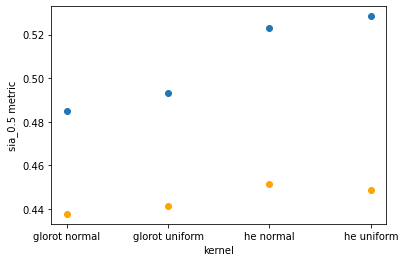

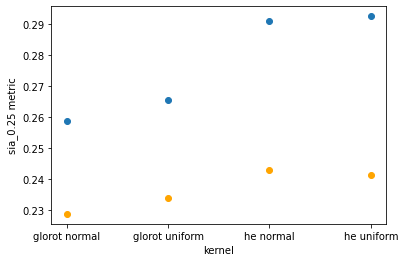

In [ ]:
X_label = ["glorot normal", "glorot uniform", "he normal", "he uniform"]

plt.scatter(X_label, y_mae_trains)
plt.scatter(X_label, y_mae_tests, color="orange")
plt.xlabel("kernel")
plt.ylabel("mae metric")
plt.show()

plt.scatter(X_label, y_mse_trains)
plt.scatter(X_label, y_mse_tests, color="orange")
plt.xlabel("kernel")
plt.ylabel("mse metric")
plt.show()

plt.scatter(X_label, y_sia_1_trains)
plt.scatter(X_label, y_sia_1_tests, color="orange")
plt.xlabel("kernel")
plt.ylabel("sia_1 metric")
plt.show()

plt.scatter(X_label, y_sia_0_5_trains)
plt.scatter(X_label, y_sia_0_5_tests, color="orange")
plt.xlabel("kernel")
plt.ylabel("sia_0.5 metric")
plt.show()

plt.scatter(X_label, y_sia_0_25_trains)
plt.scatter(X_label, y_sia_0_25_tests, color="orange")
plt.xlabel("kernel")
plt.ylabel("sia_0.25 metric")
plt.show()



In [ ]:
print(y_mae_trains)
print(y_mse_trains)
print(y_sia_1_trains)
print(y_sia_0_5_trains)
print(y_sia_0_25_trains)

print(y_mae_tests)
print(y_mse_tests)
print(y_sia_1_tests)
print(y_sia_0_5_tests)
print(y_sia_0_25_tests)

[array([0.64973983]), array([0.64246735]), array([0.60910296]), array([0.60475662])]
[array([0.70557596]), array([0.70080615]), array([0.64822935]), array([0.6415972])]
[0.7824677517390424, 0.7905450124940906, 0.8093604376308503, 0.8121699196326062]
[0.4851219018032012, 0.4931181198081988, 0.5231579658269737, 0.5284122374552577]
[0.25876950091173095, 0.2654555277909097, 0.2909569798068481, 0.2924967920578105]
[array([0.733732], dtype=float32), array([0.7308293], dtype=float32), array([0.7216326], dtype=float32), array([0.72635764], dtype=float32)]
[array([0.8920594], dtype=float32), array([0.89969504], dtype=float32), array([0.89101195], dtype=float32), array([0.90433294], dtype=float32)]
[0.7283483710627262, 0.7344535091036792, 0.7389378140364147, 0.7379653141714841]
[0.43773299475930627, 0.4414068831379329, 0.45140202063860824, 0.44859257658436436]
[0.22880760711005457, 0.23399427305635095, 0.24280079961100007, 0.2413420498136042]


In [ ]:
def get_NeuMF_model(num_users, num_items, MF_dim, MF_reg, MLP_layers, MLP_regs, kernel):
    assert len(MLP_layers) == len(MLP_regs)
    num_MLP_layer = len(MLP_layers) # Number of layers in the MLP
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    # Embedding layer
    
    # MF
    MF_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=MF_dim,
        embeddings_initializer='uniform',
        name='mf_user_embedding',
        embeddings_regularizer=l2(MF_reg[0]),
        input_length=1)
    MF_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=MF_dim,
        embeddings_initializer='uniform',
        name='mf_item_embedding',
        embeddings_regularizer=l2(MF_reg[1]),
        input_length=1)
    
    # MLP
    MLP_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=MLP_layers[0] // 2,
        embeddings_initializer='uniform',
        name='mlp_user_embedding',
        embeddings_regularizer=l2(MLP_regs[0]),
        input_length=1)
    MLP_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=MLP_layers[0] // 2,
        embeddings_initializer='uniform',
        name='mlp_item_embedding',
        embeddings_regularizer=l2(MLP_regs[0]),
        input_length=1) 
    # MF part
    mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
    mf_vector = Multiply()([mf_user_latent, mf_item_latent])

    # MLP part
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    mlp_vector = Concatenate(axis=-1)([mlp_user_latent, mlp_item_latent])
    for idx in range(1, num_MLP_layer):
        layer = Dense(
            units=MLP_layers[idx],
            activation='relu',
            kernel_initializer=kernel,
            kernel_regularizer=l2(MLP_regs[idx]),
            name = 'layer%d' %idx)
        mlp_vector = layer(mlp_vector)
    # Concatenate MF and MLP parts
    predict_vector = Concatenate(axis=-1)([mf_vector, mlp_vector])
    prediction = Dense(1, kernel_initializer=kernel, name='prediction')(predict_vector)
    
    model = Model([user_input, item_input], prediction)
    
    return model

In [ ]:
BATCH_SIZE = 64
EPOCHS = 30
VAL_SPLIT = 0.25

  0%|          | 0/4 [00:00<?, ?it/s]

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 mlp_user_embedding (Embedding)  (None, 1, 32)       44512       ['user_input[0][0]']             
                                                                                                  
 mlp_item_embedding (Embedding)  (None, 1, 32)       267296      ['item_input[0][0]']             
                                                                                           

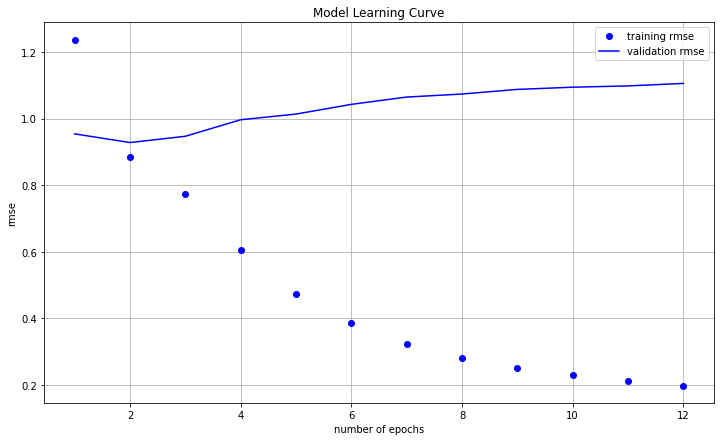

 25%|██▌       | 1/4 [01:05<03:17, 65.92s/it]

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 mlp_user_embedding (Embedding)  (None, 1, 32)       44512       ['user_input[0][0]']             
                                                                                                  
 mlp_item_embedding (Embedding)  (None, 1, 32)       267296      ['item_input[0][0]']             
                                                                                           

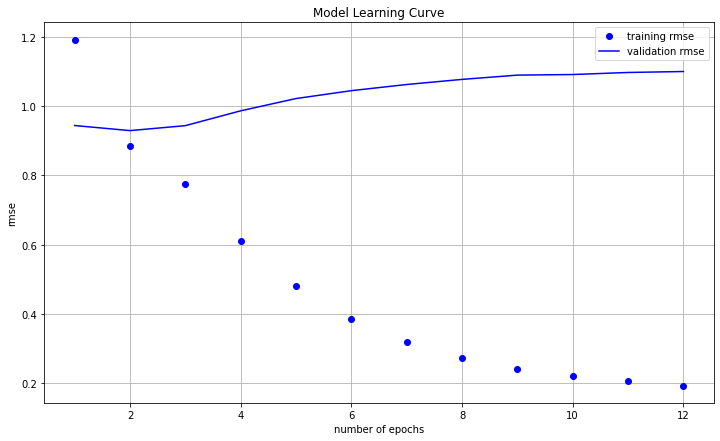

 50%|█████     | 2/4 [02:29<02:32, 76.20s/it]

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 mlp_user_embedding (Embedding)  (None, 1, 32)       44512       ['user_input[0][0]']             
                                                                                                  
 mlp_item_embedding (Embedding)  (None, 1, 32)       267296      ['item_input[0][0]']             
                                                                                           

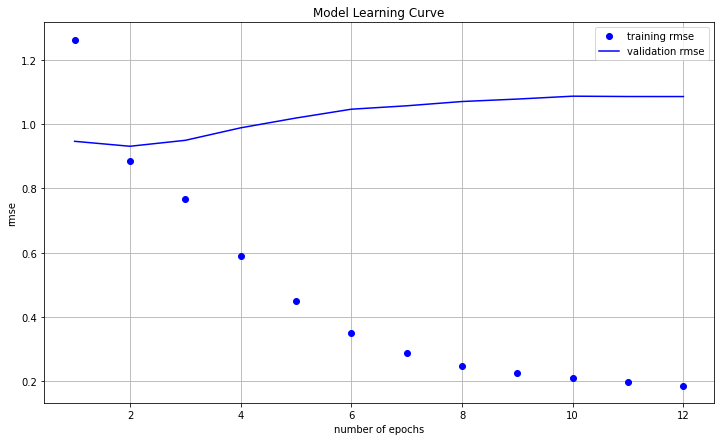

 75%|███████▌  | 3/4 [03:52<01:19, 79.47s/it]

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 mlp_user_embedding (Embedding)  (None, 1, 32)       44512       ['user_input[0][0]']             
                                                                                                  
 mlp_item_embedding (Embedding)  (None, 1, 32)       267296      ['item_input[0][0]']             
                                                                                           

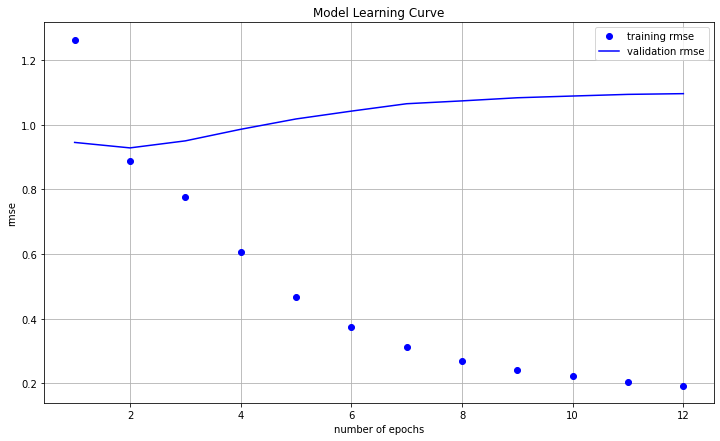

100%|██████████| 4/4 [05:16<00:00, 79.08s/it]


In [ ]:
filenames = ["./drive/MyDrive/neumf_model_glorot_normal.hdf5", "./drive/MyDrive/neumf_model_glorot_uniform.hdf5", "./drive/MyDrive/neumf_model_he_normal.hdf5", "./drive/MyDrive/neumf_model_he_uniform.hdf5"]
i = 0

for kernel in tqdm([GlorotNormal(), GlorotUniform(), HeNormal(), HeUniform()]):
  NeuMF_model = get_NeuMF_model(
    num_users=num_users,
    num_items=num_items,
    MF_dim=10,
    MF_reg=(0, 0),
    MLP_layers=[64, 32, 16, 8],
    MLP_regs=[0, 0, 0, 0], kernel = kernel)
  NeuMF_model.summary()
  
  history = train_model(NeuMF_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT, 
                      [df_train["user index"].values.astype(np.int), df_train["movie index"].values.astype(np.int)],
                      df_train.rating.values, filenames[i])
  i = i + 1
  plot_learning_curve(history, 'rmse')


In [ ]:
y_mae_trains = []
y_mse_trains = []
y_sia_1_trains = []
y_sia_0_5_trains = []
y_sia_0_25_trains = []

y_mae_tests = []
y_mse_tests = []
y_sia_1_tests = []
y_sia_0_5_tests = []
y_sia_0_25_tests = []

In [ ]:
# load best model
filenames = ["./drive/MyDrive/neumf_model_glorot_normal.hdf5", "./drive/MyDrive/neumf_model_glorot_uniform.hdf5", "./drive/MyDrive/neumf_model_he_normal.hdf5", "./drive/MyDrive/neumf_model_he_uniform.hdf5"]
i = 0

for kernel in tqdm([GlorotNormal(), GlorotUniform(), HeNormal(), HeUniform()]):
  NeuMF_model = get_NeuMF_model(
    num_users=num_users,
    num_items=num_items,
    MF_dim=10,
    MF_reg=(0, 0),
    MLP_layers=[64, 32, 16, 8],
    MLP_regs=[0, 0, 0, 0], kernel = kernel)
  NeuMF_model = load_trained_model(NeuMF_model, filenames[i])

  # make prediction using train data
  predictions_train = NeuMF_model.predict([df_train["user index"].values.astype(np.int), df_train["movie index"].values.astype(np.int)])


  y_mae_trains.append(Metrics.computeMAE(df_train.rating.values, predictions_train))
  y_mse_trains.append(Metrics.computeMSE(df_train.rating.values, predictions_train))
  y_sia_1_trains.append(Metrics.computeSIA(df_train.rating.values, predictions_train, 1))
  y_sia_0_5_trains.append(Metrics.computeSIA(df_train.rating.values, predictions_train, 0.5))
  y_sia_0_25_trains.append(Metrics.computeSIA(df_train.rating.values, predictions_train, 0.25))

  # make prediction using test data
  predictions_test = NeuMF_model.predict([df_test["user index"].values.astype(np.int), df_test["movie index"].values.astype(np.int)])


  y_mae_tests.append(Metrics.computeMAE(df_test.rating.values, predictions_test))
  y_mse_tests.append(Metrics.computeMSE(df_test.rating.values, predictions_test))
  y_sia_1_tests.append(Metrics.computeSIA(df_test.rating.values, predictions_test, 1))
  y_sia_0_5_tests.append(Metrics.computeSIA(df_test.rating.values, predictions_test, 0.5))
  y_sia_0_25_tests.append(Metrics.computeSIA(df_test.rating.values, predictions_test, 0.25))


  i = i + 1





100%|██████████| 4/4 [00:35<00:00,  8.87s/it]


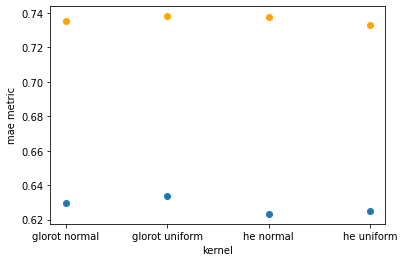

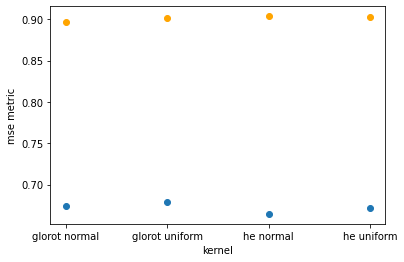

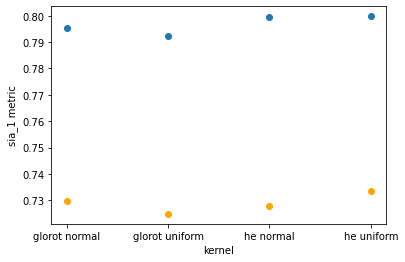

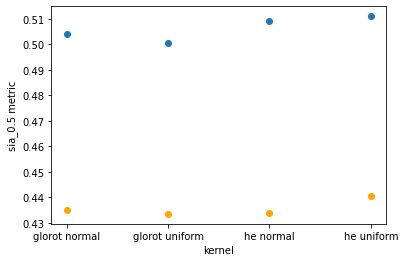

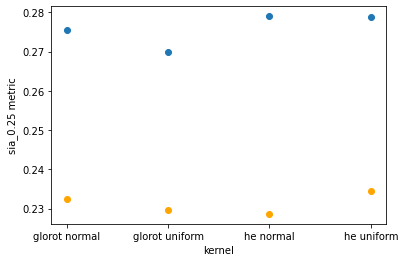

In [ ]:
X_label = ["glorot normal", "glorot uniform", "he normal", "he uniform"]

plt.scatter(X_label, y_mae_trains)
plt.scatter(X_label, y_mae_tests, color="orange")
plt.xlabel("kernel")
plt.ylabel("mae metric")
plt.show()

plt.scatter(X_label, y_mse_trains)
plt.scatter(X_label, y_mse_tests, color="orange")
plt.xlabel("kernel")
plt.ylabel("mse metric")
plt.show()

plt.scatter(X_label, y_sia_1_trains)
plt.scatter(X_label, y_sia_1_tests, color="orange")
plt.xlabel("kernel")
plt.ylabel("sia_1 metric")
plt.show()

plt.scatter(X_label, y_sia_0_5_trains)
plt.scatter(X_label, y_sia_0_5_tests, color="orange")
plt.xlabel("kernel")
plt.ylabel("sia_0.5 metric")
plt.show()

plt.scatter(X_label, y_sia_0_25_trains)
plt.scatter(X_label, y_sia_0_25_tests, color="orange")
plt.xlabel("kernel")
plt.ylabel("sia_0.25 metric")
plt.show()



In [ ]:
print(y_mae_trains)
print(y_mse_trains)
print(y_sia_1_trains)
print(y_sia_0_5_trains)
print(y_sia_0_25_trains)

print(y_mae_tests)
print(y_mse_tests)
print(y_sia_1_tests)
print(y_sia_0_5_tests)
print(y_sia_0_25_tests)

[array([0.62932465]), array([0.6336978]), array([0.6232494]), array([0.62479924])]
[array([0.67453886]), array([0.67929226]), array([0.66453768]), array([0.67145332])]
[0.7954751131221719, 0.792449517120281, 0.7995677719997298, 0.7998379144998987]
[0.504153440940096, 0.5005740528128588, 0.509353684068346, 0.5110690889444182]
[0.2754372931721483, 0.269804822043628, 0.27901668129938545, 0.27876004592422504]
[array([0.73512655], dtype=float32), array([0.7381519], dtype=float32), array([0.73750496], dtype=float32), array([0.73307884], dtype=float32)]
[array([0.89711213], dtype=float32), array([0.9016812], dtype=float32), array([0.9035202], dtype=float32), array([0.9028797], dtype=float32)]
[0.7296990653195743, 0.7247825382246474, 0.7277540655897131, 0.7336430925495705]
[0.4349235507050624, 0.43351882867794045, 0.43378896752931007, 0.4403803555027284]
[0.2324814954886812, 0.22961802366416337, 0.2286455237992328, 0.23437246744826842]
